In [55]:
################ Library imports ################
import numpy as np
import math as math
import matplotlib.pyplot as plt
import pandas as pd
import glob
import seaborn as sns
import itertools

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy.optimize import curve_fit

In [56]:
"""
Plot styling
"""
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)

sns.set_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [57]:
# ----------------------------------------------------------------------
#  AP locations
L_ap = np.array([[0, 0], [0, 2], [2, 0], [2, 2]])

# ----------------------------------------------------------------------
#  VRP locations
L_vrp = np.array([[1, 0], [0, 1], [1, 1], [1, 2], [2, 1]])

# ----------------------------------------------------------------------
#  RTT distance observations
d_RTT = np.array([0, 2, 2, math.sqrt(8)])

In [58]:
"""
Gaussian Process Kernel definition

Kernel parameters:
    - L --> Length Scale
    - sigma_f --> Constant Kernel Amplitude
"""

def kernel_function(x, y, sigma_f=1, l=1):

    """ Squared Exponential kernel function """
    kernel = sigma_f * np.exp(- (np.linalg.norm(x - y)**2) / (2 * l**2))
    return kernel

In [59]:
def compute_cov_matrices(L_ap, L_vrp, sigma_f=1, l=1):
    """
    Compute components of the covariance matrix of the joint distribution.
    
    We follow the notation:
    
        - K = K(L, L) 
        - K_star = K(L^*, L)
        - K_star2 = K(L^*, L^*)
    """
    n = L_ap.shape[0]
    n_star = L_vrp.shape[0]

    K = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(L_ap, L_ap)]

    K = np.array(K).reshape(n, n)
    
    K_star2 = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(L_vrp, L_vrp)]

    K_star2 = np.array(K_star2).reshape(n_star, n_star)
    
    K_star = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(L_vrp, L_ap)]

    K_star = np.array(K_star).reshape(n_star, n)
    
    return (K, K_star2, K_star)

In [60]:
"""
Computing covariance matrices
"""
l = 2.47
sigma_f = 4

K, K_star2, K_star = compute_cov_matrices(L_ap, L_vrp, sigma_f=sigma_f, l=l)

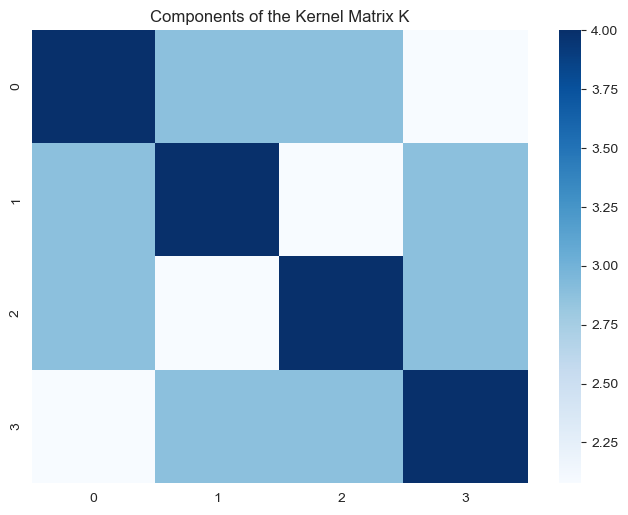

In [61]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data=K, cmap='Blues', ax=ax)
ax.set(title='Components of the Kernel Matrix K');

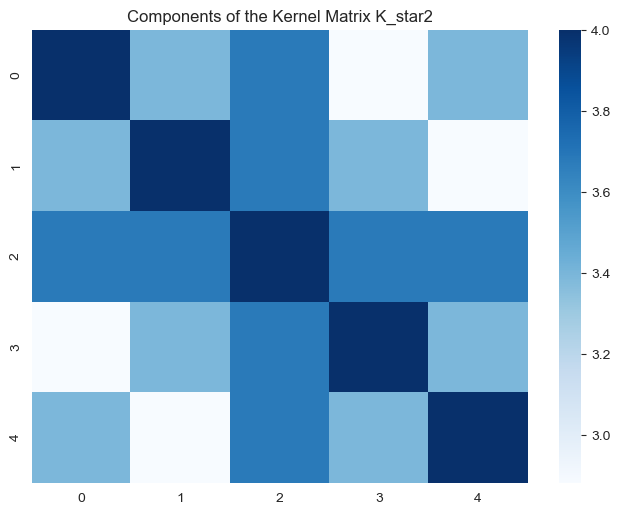

In [62]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data=K_star2, cmap='Blues', ax=ax)
ax.set(title='Components of the Kernel Matrix K_star2');

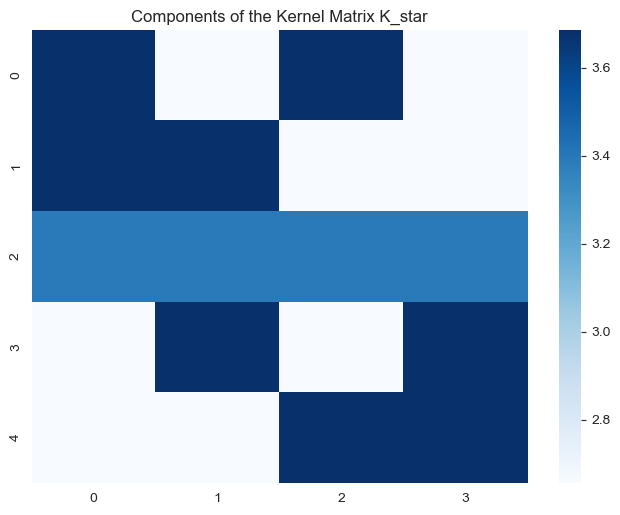

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data=K_star, cmap='Blues', ax=ax)
ax.set(title='Components of the Kernel Matrix K_star');

In [73]:
"""
Gaussian Process Regressor definition

- sigma_n --> Training Noise Variance

Multivariate Joint Distribution: G matrix
"""
n = L_ap.shape[0]
n_star = L_vrp.shape[0]
sigma_n = 0.2

a = np.concatenate((K + (sigma_n**2)*np.eye(n), K_star), axis=0)
print(a.shape)
b = np.concatenate((K_star.T, K_star2), axis=0)
print(b.shape)
G = np.concatenate((a, b), axis=1)
print(G.shape)
G.shape == (n + n_star, n + n_star)

(9, 4)
(9, 5)
(9, 9)


True

In [87]:
def compute_gpr_parameters(K, K_star2, K_star, sigma_n):
    
    """Compute gaussian regression parameters."""

    n = K.shape[0]
    
    # Mean.
    s_bar_star = np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), d_RTT.reshape([n, 1])))
    # Covariance.
    cov_s_star = K_star2 - np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), K_star.T))
    
    return (s_bar_star, cov_s_star)

In [89]:
"""
Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

s_bar_star, cov_s_star = compute_gpr_parameters(K, K_star2, K_star, sigma_n)
var_s_star = np.diag(cov_s_star)